In [1]:
import zipfile
import os

train_zip_path = 'train.zip'
validation_zip_path = 'valid.zip'

train_extract_dir = 'train_data'
validation_extract_dir = 'valid_data'

with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
    zip_ref.extractall(train_extract_dir)

with zipfile.ZipFile(validation_zip_path, 'r') as zip_ref:
    zip_ref.extractall(validation_extract_dir)


First few rows of training annotations:
                                            filename  width  height  \
0  chairnex_914_jpg.rf.90f33f9300472e4fc1ec18f790...    640     640   
1  chairnex_914_jpg.rf.90f33f9300472e4fc1ec18f790...    640     640   
2  chair2_19962_jpg.rf.97c95775fff51d9d0656fcdc79...    640     640   
3  chair2_19962_jpg.rf.97c95775fff51d9d0656fcdc79...    640     640   
4  chairnex_654_jpg.rf.944f205e1a3e29c52f18228a29...    640     640   

               class  xmin  ymin  xmax  ymax  
0  person-wheelchair   152     0   630   640  
1  person-wheelchair   170   137   610   640  
2  person-wheelchair    95    27   390   625  
3         wheelchair   107   196   389   623  
4  person-wheelchair   326   127   500   598  
First few rows of validation annotations:
                                            filename  width  height  \
0  chairnex_123_jpg.rf.0b5347271e360b6885c875c08b...    640     640   
1  chairnex_123_jpg.rf.0b5347271e360b6885c875c08b...    640     640

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4428 - loss: 1.6309
Epoch 1: val_accuracy improved from -inf to 0.42188, saving model to best_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.4447 - loss: 1.6221 - val_accuracy: 0.4219 - val_loss: 2.3220
Epoch 2/30
 1/27 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.5000 - loss: 1.2023

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy improved from 0.42188 to 0.44000, saving model to best_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 433ms/step - accuracy: 0.5000 - loss: 1.2023 - val_accuracy: 0.4400 - val_loss: 2.0190
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5007 - loss: 1.1314
Epoch 3: val_accuracy improved from 0.44000 to 0.54688, saving model to best_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.5007 - loss: 1.1304 - val_accuracy: 0.5469 - val_loss: 1.1044
Epoch 4/30
 1/27 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.4062 - loss: 1.0297
Epoch 4: val_accuracy did not improve from 0.54688
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.4062 - loss: 1.0297 - val_accuracy: 0.2800 - val_loss: 1.1582
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5170 - loss: 1.0289
Epoch 5: val_accuracy did not improve from 0.54688
27/27 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.5171 - loss: 1.0283 - val_accuracy: 0.4531 - val_loss: 1.1653
Epoch

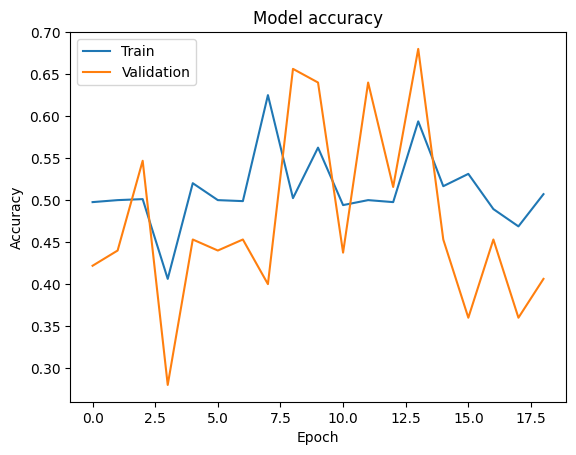

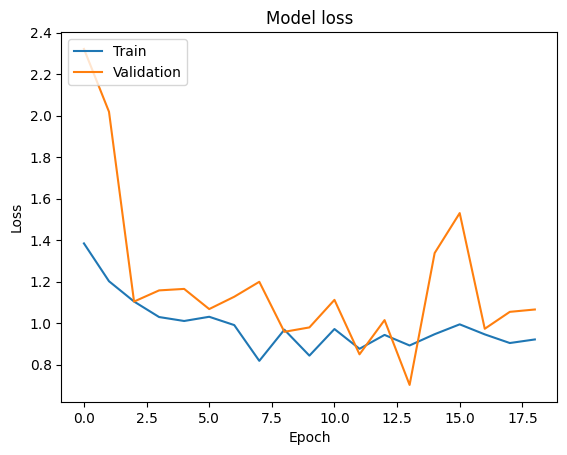

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 659ms/step


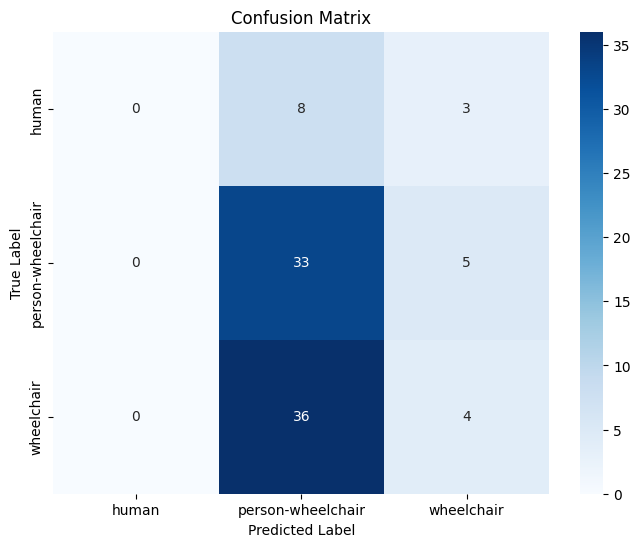

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


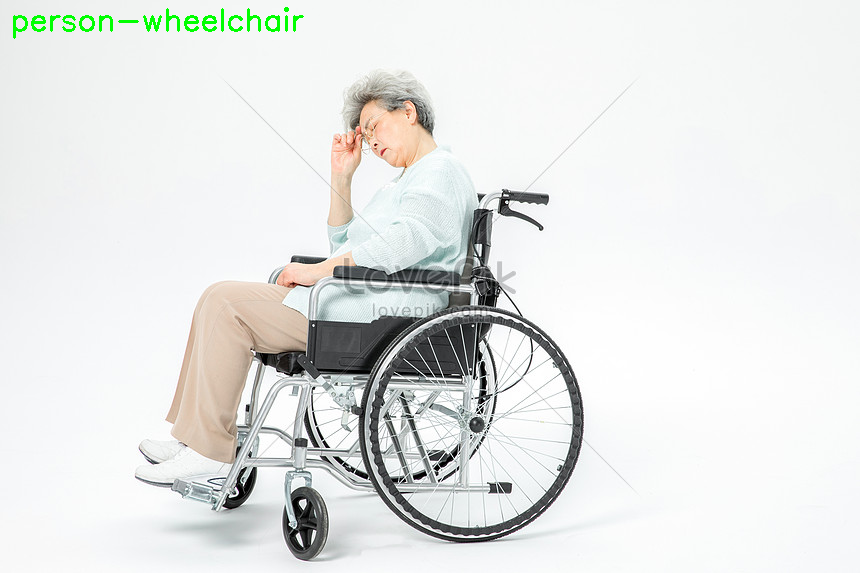

In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from google.colab.patches import cv2_imshow

train_dir = 'train_data/train'
validation_dir = 'valid_data/valid'

train_annotation = pd.read_csv('/content/train_data/train/_annotations.csv')
valid_annotation = pd.read_csv('/content/valid_data/valid/_annotations.csv')

def load_data(annotation_df, base_dir):
    images = []
    labels = []
    missing_files = 0
    for _, row in annotation_df.iterrows():
        img_path = os.path.join(base_dir, row['filename'])
        if os.path.exists(img_path):
            img = load_img(img_path)
            img_array = img_to_array(img)

            xmin, ymin, xmax, ymax = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])
            img_cropped = img_array[ymin:ymax, xmin:xmax]
            img_cropped_resized = cv2.resize(img_cropped, (150, 150))

            images.append(img_cropped_resized)
            labels.append(row['class'])
        else:
            print(f"File {img_path} not found.")
            missing_files += 1
    print(f"Total missing files: {missing_files}")
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

print("First few rows of training annotations:")
print(train_annotation.head())

print("First few rows of validation annotations:")
print(valid_annotation.head())

train_images, train_labels = load_data(train_annotation, train_dir)
valid_images, valid_labels = load_data(valid_annotation, validation_dir)

print(f"Loaded {len(train_images)} training images and {len(train_labels)} training labels.")
print(f"Loaded {len(valid_images)} validation images and {len(valid_labels)} validation labels.")

if len(train_images) == 0 or len(train_labels) == 0 or len(valid_images) == 0 or len(valid_labels) == 0:
    raise ValueError("No images or labels.")

train_images = train_images / 255.0
valid_images = valid_images / 255.0

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
valid_labels_encoded = label_encoder.transform(valid_labels)

train_labels = tf.keras.utils.to_categorical(train_labels_encoded)
valid_labels = tf.keras.utils.to_categorical(valid_labels_encoded)

train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.5, 1.5]
)

validation_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(train_images, train_labels, batch_size=32)
validation_generator = validation_datagen.flow(valid_images, valid_labels, batch_size=32)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3), kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_images) // 32,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=len(valid_images) // 32,
    callbacks=[early_stopping, model_checkpoint]
)

best_model = tf.keras.models.load_model('best_model.keras')

evaluation = best_model.evaluate(validation_generator)
print("Validation Accuracy:", evaluation[1])

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

predictions = best_model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(valid_labels, axis=1)
class_labels = list(label_encoder.classes_)
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

def preprocess_frame(frame):
    frame = cv2.resize(frame, (150, 150))
    frame = frame.astype('float32') / 255
    frame = np.expand_dims(frame, axis=0)
    return frame

img_path = '/content/test.png'

frame = cv2.imread(img_path)
if frame is not None:
    preprocessed_frame = preprocess_frame(frame)
    prediction = best_model.predict(preprocessed_frame)[0]

    label = class_labels[np.argmax(prediction)]

    cv2.putText(frame, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2_imshow(frame)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
else:
    print("Error: Image not found.")
